
    This Source Code Form is subject to the terms of the Mozilla Public
    License, v. 2.0. If a copy of the MPL was not distributed with this
    file, You can obtain one at http://mozilla.org/MPL/2.0/.


In [1]:
# Enable automatic module reload
%load_ext autoreload
%autoreload 2

# Load EPEACS module
from epeacs.agents.epeacs import EPEACS, Configuration

from epeacs.agents.epeacs.utils.Plotting_wrapper import \
    parse_metrics_to_df, \
    plot_performance

from epeacs.metrics import \
    _maze_metrics, \
    _how_many_peps_match_non_aliased_states, \
    _mean_reliable_classifier_specificity, \
    _when_full_knowledge_is_achieved, \
    _state_of_population, \
    _enhanced_effect_error

# Load environments
import gym
import my_mazes

# Agent - EPEACS

## Common parameters

In [2]:
RANDOM_ATTRIBUTE_LENGTH = 0
CLASSIFIER_LENGTH = 8 + RANDOM_ATTRIBUTE_LENGTH
NUMBER_OF_POSSIBLE_ACTIONS = 8

MAZE = "MazeE2-v0"

NUMBER_OF_EXPLORE_TRIALS = 1000
METRICS_TRIAL_FREQUENCY_EXPLORE = 100
BETA_ALP = 0.05
BETA_RL = 0.05
BETA_PEP = 0.01
EPSILON = 0.8

DO_GA = False
ENABLE_PEP = True

SLIPPERY_PROB = 0.

NUMBER_OF_EXPLOIT_TRIALS_NO_RL = 500
BETA_EXPLOIT_NO_RL = 0.00

NUMBER_OF_EXPLOIT_TRIALS_RL_START = 500
BETA_EXPLOIT_RL_START = 0.05

NUMBER_OF_EXPLOIT_TRIALS_RL = 500
BETA_EXPLOIT_RL = 0.05

LENGTH_OF_BEHAVIORAL_SEQUENCES = 1

## Environment - Maze

In [3]:
# Initialize environment
maze = gym.make(MAZE)
# Set up probability to do a random action
maze.env.set_prob_slippery(SLIPPERY_PROB)
# Set up random attribute length
maze.env.set_random_attribute_length(RANDOM_ATTRIBUTE_LENGTH)
# Reset it, by putting an agent into random position
maze.reset()
# Render the state in ASCII
maze.render('aliasing_human')
# Get environmental state transitions
#maze.env.get_theoritical_probabilities()


■ ■ ■ ■ ■ ■ ■ ■ ■
■ □ ■ ■ ■ ■ ■ □ ■
■ ■ ■ ■ ■ ■ ■ ■ ■
■ ■ ■ □ □ □ ■ ■ ■
■ ■ ■ □ $ □ A ■ ■
■ ■ ■ □ □ □ ■ ■ ■
■ ■ ■ ■ ■ ■ ■ ■ ■
■ □ ■ ■ ■ ■ ■ □ ■
■ ■ ■ ■ ■ ■ ■ ■ ■


## Training of EPEACS - Exploration

In [4]:
%%time

cfg_explore = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=METRICS_TRIAL_FREQUENCY_EXPLORE,
    do_pep=ENABLE_PEP,
    do_ga=DO_GA,
    beta_alp=BETA_ALP,
    beta_rl=BETA_RL,
    beta_pep=BETA_PEP,
    gamma=0.95,
    theta_i=0.1,
    theta_r=0.9,
    epsilon=EPSILON,
    u_max=CLASSIFIER_LENGTH,
    theta_exp=20,
    theta_ga=100,
    theta_bseq=1000,
    theta_as=20,
    mu=0.3,
    chi=0.8,
    bs_max=LENGTH_OF_BEHAVIORAL_SEQUENCES
)

agent_explore = EPEACS(cfg_explore)
population_explore, metrics_explore = agent_explore.explore(maze, NUMBER_OF_EXPLORE_TRIALS)

CPU times: user 12min 59s, sys: 4.31 s, total: 13min 3s
Wall time: 14min 35s


### Performance

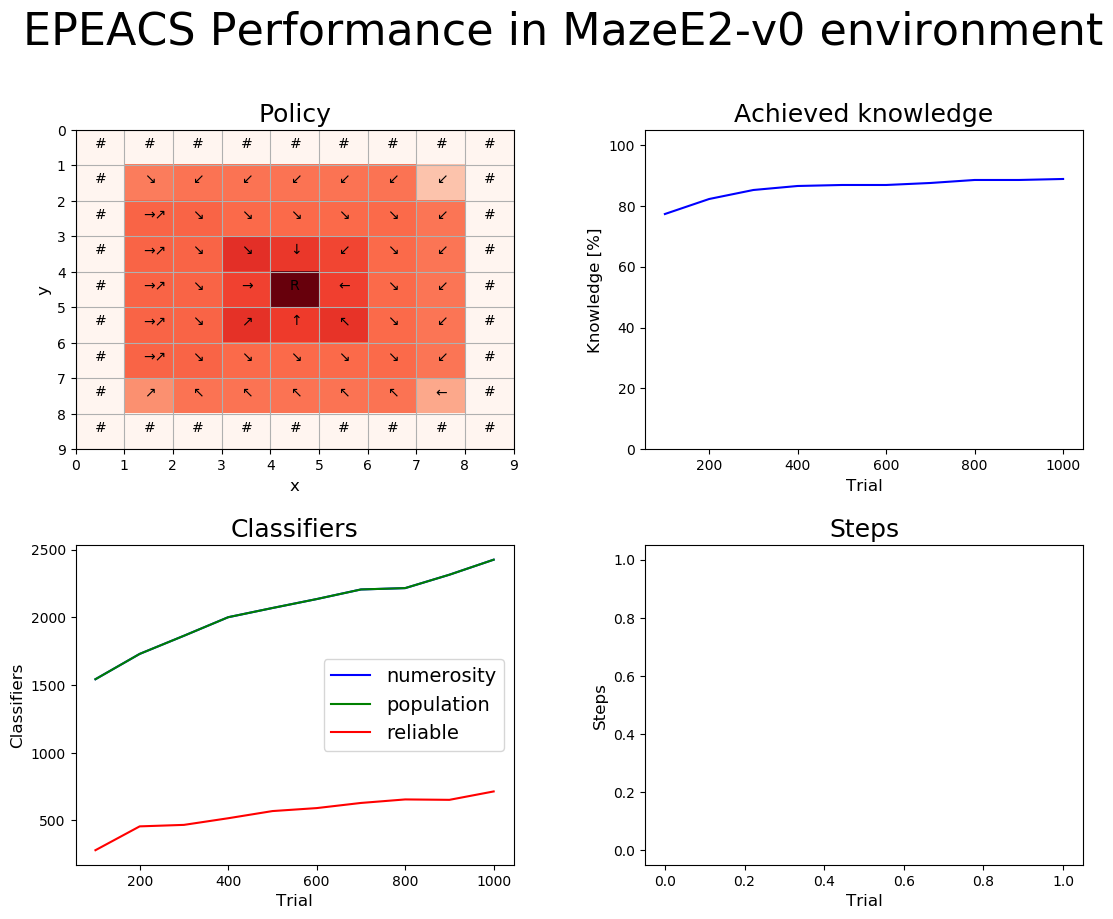

In [5]:
metrics_trial_frequency_explore = cfg_explore.metrics_trial_frequency

metrics_df = parse_metrics_to_df(metrics_explore, metrics_trial_frequency_explore, None, None)
plot_performance(agent_explore, maze, metrics_df, cfg_explore, MAZE, metrics_trial_frequency_explore, None)

In [6]:
print(_maze_metrics(population_explore, maze))

first_trial, stable_trial, last_trial = _when_full_knowledge_is_achieved(metrics_explore)

print("Full knowledge was achieved at trials ", first_trial, ", was stable at ", stable_trial, 
        " and the last time it was achieved at ", last_trial)

print("There are ", _how_many_peps_match_non_aliased_states(population_explore, maze),
      " enhanced classifer(s) that match a non-aliased states.")

print("Mean reliable population specifity is ",
      _mean_reliable_classifier_specificity(population_explore, maze))

print(_state_of_population(metrics_explore, last_trial, METRICS_TRIAL_FREQUENCY_EXPLORE))

old_error, new_error = _enhanced_effect_error(population_explore, maze, CLASSIFIER_LENGTH, RANDOM_ATTRIBUTE_LENGTH)
print("Accumulated Error on PEP Probabilities : old->", old_error, "% new->", new_error, "%")

{'knowledge': 88.81578947368422, 'population': 2426, 'numerosity': 2426, 'reliable': 714}
Full knowledge was achieved at trials  -1 , was stable at  -1  and the last time it was achieved at  -1
There are  0  enhanced classifer(s) that match a non-aliased states.
Mean reliable population specifity is  0.6710434173669467
{'trial': 900, 'steps_in_trial': 11, 'reward': 1000, 'knowledge': 88.48684210526315, 'population': 2315, 'numerosity': 2315, 'reliable': 652}
Accumulated Error on PEP Probabilities : old-> 2.007354061902587 % new-> 1.150517572233454 %


In [7]:
population_explore.sort(key=lambda cl: -cl.fitness)
population_explore_to_display = [cl for cl in population_explore
    if cl.is_reliable()]
for cl in population_explore_to_display:
    print(cl)
    print(cl.effect.print_detailled_counter())
    print("\n")

###9#### 3 None ###0####         (empty)               
q: 1.0   ra: 992.3  rb: 990.1  ir: 999.9  f: 992.3  
exp: 185 tga: 2     tbseq: 29885 talp: 30376 tav: 1.41e+02 num: 1 ee: False



00090000 3 None ###0####         (empty)               
q: 1.0   ra: 990.8  rb: 990.8  ir: 999.9  f: 990.8  
exp: 182 tga: 1354  tbseq: 29885 talp: 30376 tav: 1.41e+02 num: 1 ee: False



09000000 1 None #0######         (empty)               
q: 1.0   ra: 968.9  rb: 984.7  ir: 999.5  f: 984.6  
exp: 148 tga: 1474  tbseq: 30001 talp: 29947 tav: 1.96e+02 num: 1 ee: False



09#00000 1 None #0######         (empty)               
q: 1.0   ra: 981.2  rb: 974.6  ir: 999.5  f: 981.0  
exp: 148 tga: 1474  tbseq: 30001 talp: 29947 tav: 1.96e+02 num: 1 ee: False



#9###### 1 None #0######         (empty)               
q: 1.0   ra: 978.7  rb: 976.4  ir: 999.5  f: 978.4  
exp: 148 tga: 1474  tbseq: 30001 talp: 29947 tav: 1.96e+02 num: 1 ee: False



#######9 7 None #######0         (empty)               
q: 0


00#00111 2 [6] ########         (empty)               
q: 0.95  ra: 387.5  rb: 409.3  ir: 0.0    f: 378.6  
exp: 43  tga: 6676  tbseq: 6676  talp: 30253 tav: 5.27e+02 num: 1 ee: False



1100#001 3 None 00#####0         (11000001)            
q: 0.98  ra: 385.3  rb: 376.8  ir: 0.08211 f: 377.5  
exp: 93  tga: 884   tbseq: 29560 talp: 30281 tav: 5.84e+02 num: 1 ee: True



#0##0111 2 [6] ########         (empty)               
q: 0.95  ra: 404.6  rb: 386.9  ir: 0.0    f: 376.0  
exp: 43  tga: 6366  tbseq: 6366  talp: 30253 tav: 5.32e+02 num: 1 ee: False



0##0##90 4 None ######09         (empty)               
q: 0.948 ra: 375.0  rb: 396.6  ir: 0.0    f: 375.9  
exp: 43  tga: 1442  tbseq: 29634 talp: 29969 tav: 9.13e+02 num: 1 ee: False



#1##0#11 0 None ########         (empty)               
q: 0.998 ra: 295.9  rb: 374.5  ir: 0.0    f: 373.9  
exp: 89  tga: 890   tbseq: 29992 talp: 30089 tav: 4.52e+02 num: 1 ee: False



0111#0## 6 None #000####         (empty)               
q: 0.

In [8]:
agent_explore.get_pai_states_memory()

[('0', '0', '0', '0', '0', '0', '0', '0'),
 ('0', '0', '0', '0', '0', '1', '1', '1'),
 ('0', '0', '0', '1', '1', '1', '0', '0'),
 ('0', '1', '1', '1', '0', '0', '0', '0'),
 ('1', '1', '0', '0', '0', '0', '0', '1')]

## Training of EPEACS - Exploitation

In [9]:
%%time

cfg_exploit_no_rl = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=1,
    do_pep=ENABLE_PEP,
    do_ga=False,
    beta_alp=BETA_ALP,
    beta_rl=BETA_EXPLOIT_NO_RL,
    beta_pep=BETA_PEP,
    gamma=0.95,
    theta_i=0.1,
    theta_r=0.9,
    epsilon=0.0,
    u_max=CLASSIFIER_LENGTH,
    theta_exp=20,
    theta_ga=100,
    theta_bseq=1000,
    theta_as=20,
    mu=0.3,
    chi=0.8,
    bs_max=LENGTH_OF_BEHAVIORAL_SEQUENCES
)

agent_exploit_no_rl = EPEACS(cfg_exploit_no_rl, population_explore)
#agent_exploit_no_rl.zip_population()
population_exploit_no_rl, metrics_exploit_no_rl = agent_exploit_no_rl.exploit(maze, NUMBER_OF_EXPLOIT_TRIALS_NO_RL)

CPU times: user 6min 18s, sys: 2.59 s, total: 6min 21s
Wall time: 6min 52s


In [10]:
%%time

cfg_exploit_rl_start = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=1,
    do_pep=ENABLE_PEP,
    do_ga=False,
    beta_alp=BETA_ALP,
    beta_rl=BETA_EXPLOIT_RL_START,
    beta_pep=BETA_PEP,
    gamma=0.95,
    theta_i=0.1,
    theta_r=0.9,
    epsilon=0.0,
    u_max=CLASSIFIER_LENGTH,
    theta_exp=20,
    theta_ga=100,
    theta_bseq=1000,
    theta_as=20,
    mu=0.3,
    chi=0.8,
    bs_max=LENGTH_OF_BEHAVIORAL_SEQUENCES
)

agent_exploit_rl_start = EPEACS(cfg_exploit_rl_start, population_exploit_no_rl)
#agent_exploit_rl_start.zip_population()
population_exploit_rl_start, metrics_exploit_rl_start = agent_exploit_rl_start.exploit(maze, NUMBER_OF_EXPLOIT_TRIALS_RL_START)

CPU times: user 3min 11s, sys: 1.65 s, total: 3min 13s
Wall time: 3min 29s


In [11]:
%%time

cfg_exploit_rl = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=1,
    do_pep=ENABLE_PEP,
    do_ga=False,
    beta_alp=BETA_ALP,
    beta_rl=BETA_EXPLOIT_RL,
    beta_pep=BETA_PEP,
    gamma=0.95,
    theta_i=0.1,
    theta_r=0.9,
    epsilon=0.0,
    u_max=CLASSIFIER_LENGTH,
    theta_exp=20,
    theta_ga=100,
    theta_bseq=1000,
    theta_as=20,
    mu=0.3,
    chi=0.8,
    bs_max=LENGTH_OF_BEHAVIORAL_SEQUENCES
)

agent_exploit_rl = EPEACS(cfg_exploit_rl, population_exploit_rl_start)
#agent_exploit_rl.zip_population()
population_exploit_rl, metrics_exploit_rl = agent_exploit_rl.exploit(maze, NUMBER_OF_EXPLOIT_TRIALS_RL)

CPU times: user 3min 3s, sys: 1.71 s, total: 3min 4s
Wall time: 3min 27s


### Performance

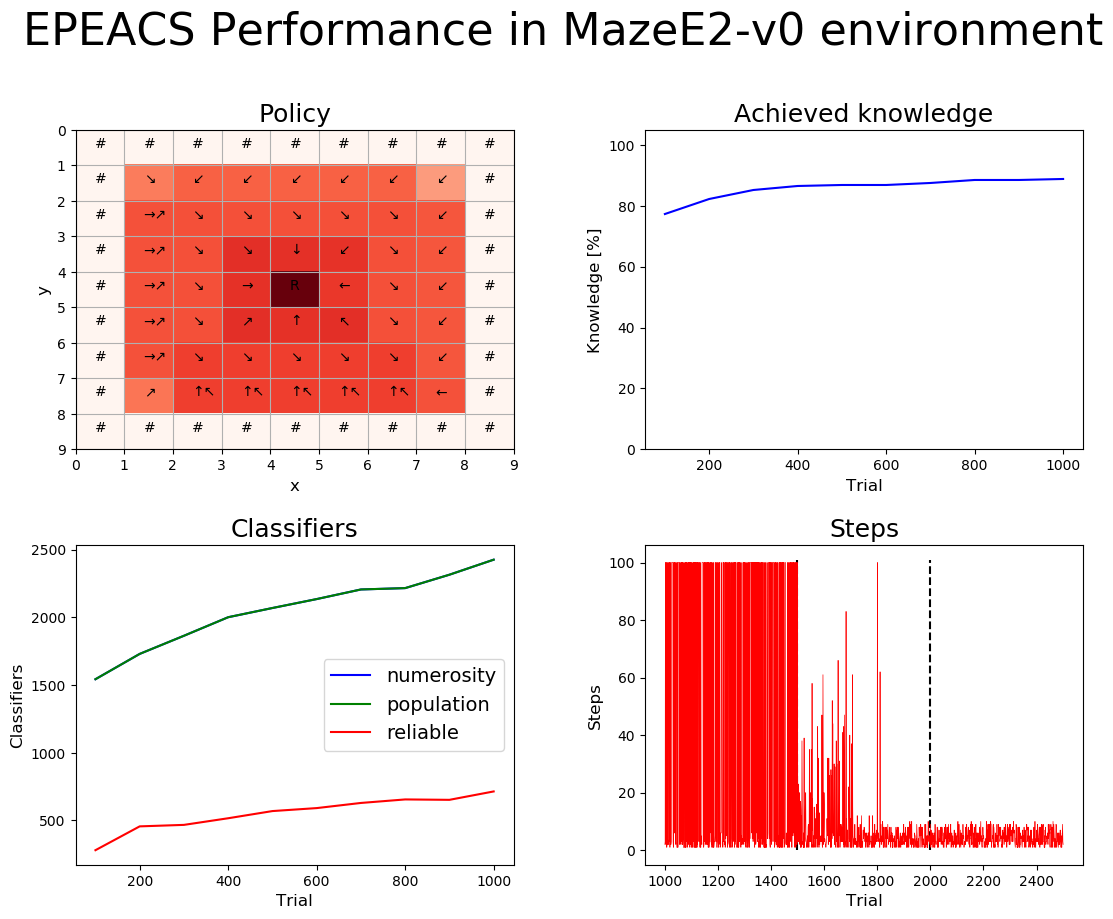

In [12]:
metrics_trial_frequency_explore = cfg_explore.metrics_trial_frequency
metrics_trial_frequency_exploit = 1

metrics_exploit = metrics_exploit_no_rl.copy()
for idx, item in enumerate(metrics_exploit_rl_start):
    tmp = item.copy()
    tmp['trial'] += NUMBER_OF_EXPLOIT_TRIALS_NO_RL
    metrics_exploit.append(tmp)
for idx, item in enumerate(metrics_exploit_rl):
    tmp = item.copy()
    tmp['trial'] += NUMBER_OF_EXPLOIT_TRIALS_NO_RL + NUMBER_OF_EXPLOIT_TRIALS_RL_START
    metrics_exploit.append(tmp)

metrics_df = parse_metrics_to_df(metrics_explore, metrics_trial_frequency_explore, metrics_exploit, metrics_trial_frequency_exploit)
plot_performance(agent_exploit_rl, maze, metrics_df, cfg_exploit_rl, MAZE, metrics_trial_frequency_explore, [NUMBER_OF_EXPLOIT_TRIALS_NO_RL,NUMBER_OF_EXPLOIT_TRIALS_RL_START,NUMBER_OF_EXPLOIT_TRIALS_RL])

In [13]:
avg_step_explore = 0
for trial in metrics_explore:
    avg_step_explore += trial['steps_in_trial']
avg_step_explore /= NUMBER_OF_EXPLORE_TRIALS / metrics_trial_frequency_explore
print("Average number of steps to solve the maze is ",avg_step_explore,
      " for a total of ", NUMBER_OF_EXPLORE_TRIALS, " trials in EXPLORATION")

avg_step_exploit_no_rl = 0
for trial in metrics_exploit_no_rl:
    avg_step_exploit_no_rl += trial['steps_in_trial']
avg_step_exploit_no_rl /= NUMBER_OF_EXPLOIT_TRIALS_NO_RL
print("Average number of steps to solve the maze is ",avg_step_exploit_no_rl,
      " for a total of ", NUMBER_OF_EXPLOIT_TRIALS_NO_RL, " trials in EXPLOITATION without Reinforcement Module")

avg_step_exploit_rl_start = 0
for trial in metrics_exploit_rl_start:
    avg_step_exploit_rl_start += trial['steps_in_trial']
avg_step_exploit_rl_start /= NUMBER_OF_EXPLOIT_TRIALS_RL_START
print("Average number of steps to solve the maze is ",avg_step_exploit_rl_start,
      " for a total of ", NUMBER_OF_EXPLOIT_TRIALS_RL_START, " trials in EXPLOITATION starting Reinforcement Module")

avg_step_exploit_rl = 0
for trial in metrics_exploit_rl:
    avg_step_exploit_rl += trial['steps_in_trial']
avg_step_exploit_rl /= NUMBER_OF_EXPLOIT_TRIALS_RL
print("Average number of steps to solve the maze is ",avg_step_exploit_rl,
      " for a total of ", NUMBER_OF_EXPLOIT_TRIALS_RL, " trials in EXPLOITATION with Reinforcement Module")

print(_maze_metrics(population_explore, maze))
print(_maze_metrics(population_exploit_no_rl, maze))
print(_maze_metrics(population_exploit_rl_start, maze))
print(_maze_metrics(population_exploit_rl, maze))

Average number of steps to solve the maze is  50.4  for a total of  1000  trials in EXPLORATION
Average number of steps to solve the maze is  49.858  for a total of  500  trials in EXPLOITATION without Reinforcement Module
Average number of steps to solve the maze is  7.318  for a total of  500  trials in EXPLOITATION starting Reinforcement Module
Average number of steps to solve the maze is  4.376  for a total of  500  trials in EXPLOITATION with Reinforcement Module
{'knowledge': 88.81578947368422, 'population': 2426, 'numerosity': 2426, 'reliable': 714}
{'knowledge': 88.81578947368422, 'population': 2426, 'numerosity': 2426, 'reliable': 714}
{'knowledge': 88.81578947368422, 'population': 2426, 'numerosity': 2426, 'reliable': 714}
{'knowledge': 88.81578947368422, 'population': 2426, 'numerosity': 2426, 'reliable': 714}


In [14]:
population_exploit_rl.sort(key=lambda cl: -cl.fitness)
population_exploit_rl_to_display = [cl for cl in population_exploit_rl 
    if cl.pai_state]
print(len(population_exploit_rl_to_display))
print("\n")
for cl in population_exploit_rl_to_display:
    print(cl)
    print(cl.pai_state)
    print("\n")

1174


00011100 0 [7] {0:52.95% (78.26%), 9:47.05% (21.74%)}{0:85.04% (79.17%), 9:14.96% (20.83%)}#{0:100.00% (100.00%)}{0:100.00% (100.00%)}{0:84.33% (75.00%), 1:15.67% (25.00%)}{0:84.33% (75.00%), 1:15.67% (25.00%)}{0:61.32% (64.00%), 9:23.66% (12.00%), 1:15.02% (24.00%)} (empty)               
q: 1.0   ra: 917.7  rb: 926.5  ir: 0.0    f: 922.1  
exp: 22  tga: 27707 tbseq: 27707 talp: 30249 tav: 1.16e+02 num: 1 ee: False
('0', '0', '0', '0', '0', '0', '0', '0')


00011100 0 [7] #{0:66.79% (73.33%), 9:33.21% (26.67%)}#{0:100.00% (100.00%)}{0:100.00% (100.00%)}{0:84.67% (66.67%), 1:15.33% (33.33%)}{0:84.67% (66.67%), 1:15.33% (33.33%)}{9:45.91% (23.53%), 0:39.47% (47.06%), 1:14.63% (29.41%)} (00011100)            
q: 0.967 ra: 929.0  rb: 912.5  ir: 0.0    f: 890.6  
exp: 16  tga: 28023 tbseq: 28023 talp: 30249 tav: 1.39e+02 num: 1 ee: True
('0', '0', '0', '0', '0', '0', '0', '0')


00011100 0 [7] {0:52.52% (73.91%), 9:47.48% (26.09%)}{0:67.14% (79.17%), 9:32.86% (20.83%)}#{0:100.00% (1



00000000 6 [4] ######9#         (00000000)            
q: 0.488 ra: 577.9  rb: 518.8  ir: 0.0    f: 267.5  
exp: 48  tga: 17437 tbseq: 17437 talp: 30271 tav: 2.24e+02 num: 1 ee: True
('0', '0', '0', '0', '0', '0', '0', '0')


011100#0 5 [1] ######0#         (01110000)            
q: 0.999 ra: 369.0  rb: 166.1  ir: 0.0    f: 267.2  
exp: 43  tga: 3345  tbseq: 3345  talp: 29117 tav: 6.08e+02 num: 1 ee: False
('0', '0', '0', '0', '0', '0', '0', '0')


11###111 3 [3] 00090000         (11000111)            
q: 0.663 ra: 401.8  rb: 402.8  ir: 0.0    f: 266.8  
exp: 27  tga: 2915  tbseq: 2915  talp: 30187 tav: 9.7e+02 num: 1 ee: False
('0', '0', '0', '0', '0', '0', '0', '0')


00000000 6 [4] ###{0:75.67% (75.00%), 9:24.33% (25.00%)}{0:67.27% (75.00%), 9:32.73% (25.00%)}#{0:66.94% (75.00%), 9:33.06% (25.00%)}# (00000000)            
q: 0.486 ra: 536.9  rb: 554.8  ir: 0.0    f: 265.1  
exp: 9   tga: 28829 tbseq: 28829 talp: 30271 tav: 1.6e+02 num: 1 ee: False
('0', '0', '0', '0', '0', '0', '0

exp: 40  tga: 5070  tbseq: 5070  talp: 29098 tav: 5.99e+02 num: 1 ee: False
('0', '0', '0', '0', '0', '0', '0', '0')


00000000 7 [5] #####{0:50.49% (62.50%), 1:49.51% (37.50%)}{0:50.49% (62.50%), 1:49.51% (37.50%)}{0:50.49% (62.50%), 1:49.51% (37.50%)} (00000000)            
q: 0.816 ra: 218.0  rb: 227.6  ir: 0.0    f: 181.9  
exp: 10  tga: 27172 tbseq: 27172 talp: 30093 tav: 2.92e+02 num: 1 ee: False
('1', '1', '0', '0', '0', '0', '0', '1')


11#0#0#1 4 [5] 00###11#         (11000001)            
q: 0.37  ra: 487.6  rb: 487.4  ir: 0.0    f: 180.6  
exp: 39  tga: 26120 tbseq: 26120 talp: 30386 tav: 1.02e+02 num: 1 ee: True
('0', '0', '0', '0', '0', '0', '0', '0')


0#09#### 6 [5] ###0#111         (empty)               
q: 0.811 ra: 204.9  rb: 239.6  ir: 0.0    f: 180.3  
exp: 20  tga: 4421  tbseq: 4421  talp: 30140 tav: 1.29e+03 num: 1 ee: False
('0', '0', '0', '0', '0', '0', '0', '0')


#11##1## 6 [1] ####00##         (empty)               
q: 0.881 ra: 196.2  rb: 212.8  ir: 0.0    f



#9###### 5 [7] 00000111         (09000000)            
q: 0.658 ra: 160.9  rb: 145.9  ir: 0.0    f: 100.9  
exp: 15  tga: 5489  tbseq: 5489  talp: 29935 tav: 1.63e+03 num: 1 ee: False
('0', '0', '0', '0', '0', '0', '0', '0')


#0#00111 3 [7] 0#0#####         (00000111)            
q: 0.457 ra: 204.5  rb: 237.6  ir: 0.0    f: 100.9  
exp: 16  tga: 20696 tbseq: 20696 talp: 29994 tav: 5.81e+02 num: 1 ee: False
('0', '0', '0', '0', '0', '0', '0', '0')


000000#9 5 [1] ######0#         (00000009)            
q: 0.584 ra: 221.1  rb: 124.1  ir: 0.0    f: 100.8  
exp: 11  tga: 4570  tbseq: 4570  talp: 26654 tav: 2.01e+03 num: 1 ee: False
('0', '0', '0', '0', '0', '0', '0', '0')


#0#9#### 6 [5] 0#000111         (00090000)            
q: 0.59  ra: 188.4  rb: 152.9  ir: 0.0    f: 100.7  
exp: 11  tga: 19070 tbseq: 19070 talp: 30140 tav: 1.01e+03 num: 1 ee: False
('0', '0', '0', '0', '0', '0', '0', '0')


0009#### 6 [7] ###00111         (00090000)            
q: 0.48  ra: 219.4  rb: 199.9  ir: 

('0', '0', '0', '0', '0', '0', '0', '0')


#0#9#### 5 [5] 0#000111         (00090000)            
q: 0.628 ra: 111.1  rb: 165.8  ir: 0.0    f: 87.0   
exp: 12  tga: 4891  tbseq: 4891  talp: 28337 tav: 1.95e+03 num: 1 ee: False
('0', '0', '0', '0', '0', '0', '0', '0')


0###0111 2 [7] #000####         (00000111)            
q: 0.724 ra: 106.1  rb: 134.2  ir: 0.0    f: 86.97  
exp: 7   tga: 26743 tbseq: 26743 talp: 30011 tav: 4.67e+02 num: 1 ee: False
('0', '0', '0', '0', '0', '0', '0', '0')


00000000 3 [1] #11111##         (00000000)            
q: 0.183 ra: 490.1  rb: 458.3  ir: 49.35  f: 86.9   
exp: 47  tga: 12692 tbseq: 12692 talp: 30341 tav: 3.85e+02 num: 1 ee: True
('0', '0', '0', '0', '0', '0', '0', '0')


#9#0#### 4 [7] 000#0000         (09000000)            
q: 0.486 ra: 216.8  rb: 139.7  ir: 0.0    f: 86.68  
exp: 15  tga: 8037  tbseq: 8037  talp: 28891 tav: 1.39e+03 num: 1 ee: False
('0', '0', '0', '0', '0', '0', '0', '0')


#0#9#### 6 [7] 0#000111         (00090000)        

('0', '0', '0', '0', '0', '0', '0', '0')


011100#0 5 [7] #000##0#         (01110000)            
q: 0.947 ra: 68.13  rb: 0.0    ir: 0.0    f: 32.25  
exp: 2   tga: 29540 tbseq: 29540 talp: 29581 tav: 20.5   num: 1 ee: False
('0', '0', '0', '0', '0', '0', '0', '0')


1111#0#1 5 [7] ##000#0#         (11110001)            
q: 0.949 ra: 31.78  rb: 35.07  ir: 0.0    f: 31.71  
exp: 3   tga: 12110 tbseq: 12110 talp: 26753 tav: 4.88e+03 num: 1 ee: False
('0', '0', '0', '0', '0', '0', '0', '0')


###90### 0 [0] 1100#001         (00090000)            
q: 0.117 ra: 295.1  rb: 247.5  ir: 0.0    f: 31.7   
exp: 35  tga: 3701  tbseq: 3701  talp: 30170 tav: 7.39e+02 num: 1 ee: False
('0', '0', '0', '0', '0', '0', '0', '0')


9000##00 4 [3] 0##111##         (empty)               
q: 0.986 ra: 31.15  rb: 33.1   ir: 0.0    f: 31.68  
exp: 2   tga: 25860 tbseq: 25860 talp: 29006 tav: 1.57e+03 num: 1 ee: False
('0', '0', '0', '0', '0', '0', '0', '0')


1#1####1 4 [5] 0000###0         (empty)            